# Fit performance curves
This notebook is for reading in the performance curve data from the detector simulations and fitting them to some appropriate curves. The notebook plots these curves and also saves the data to the readouts folder so that it can be used in the sensitivity calculations.

There is a slight difference in the naming conventions that Sven and I have used, so part of the reason for all of this is to convert between the two and to unpack the way the data files are formatted into something more accessible.

The fits aren't *perfect* because we need less messy data, but they will do for now. The ranking of the readouts should be roughly correct which is the main thing. Also would be nice to have the data out to 200 keV, but for now it's fine to extrapolate.

## Angular resolution and head-tail efficiency

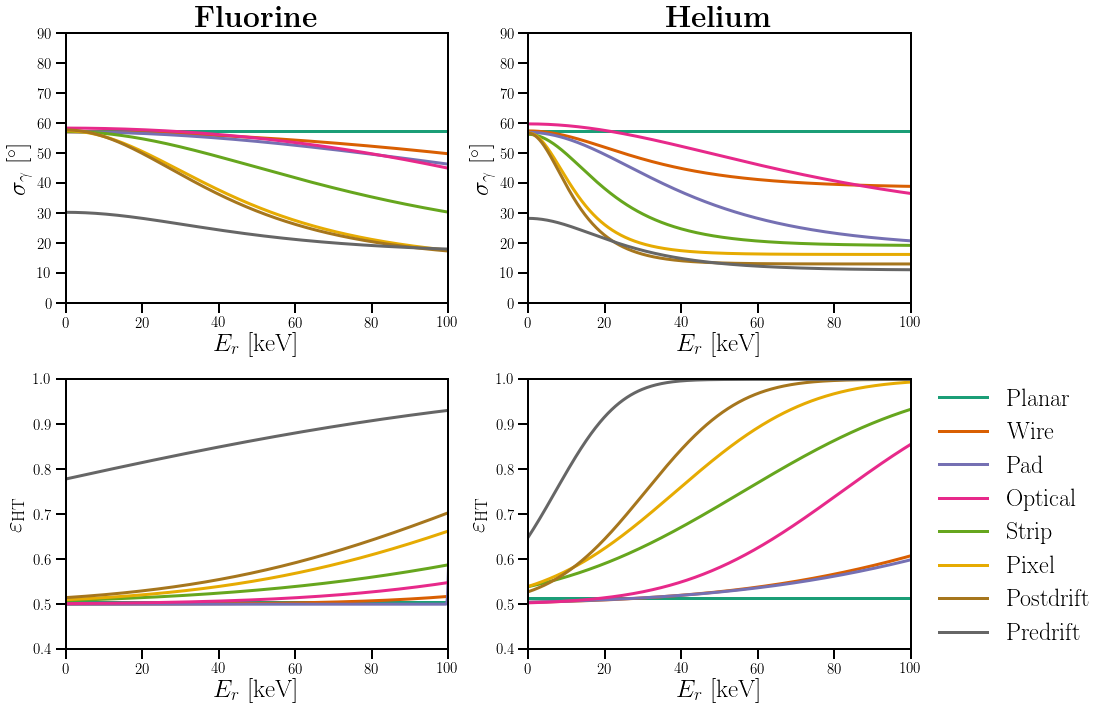

In [7]:
from numpy import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.special import erf
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

plt.rcParams['axes.linewidth'] = 2
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

col = cm.Dark2(linspace(0,1,8))

fig, ax = plt.subplots(2,2)
fig.set_size_inches(13,10)

smooth_w = 61
smooth_i = 2
def headtail_func(z,a,b):
    return 0.25*(erf((z-a)/b)+3);

def angres_func(z,a,b,c):
    return a/cosh(z/c)+b

# Sven's names
readouts = ["" for x in range(0,8)]
readouts[0] = "gem_after_threshold"
readouts[1] = "wir_after_threshold"
readouts[2] = "pad_after_threshold"
readouts[3] = "opt_after_threshold"
readouts[4] = "str_after_threshold"
readouts[5] = "pix_after_threshold"
readouts[6] = "3d_noquant_after_drift"
readouts[7] = "3d_noquant_before_drift"

# My names
froot_ar = "-AngRes.txt"
fdir_ar = "../readouts/angres/"
froot_ht = "-HeadTail.txt"
fdir_ht = "../readouts/headtail/"
fname = ["" for x in range(0,8)]
fname[0] ="Planar"
fname[1] ="Wire"
fname[2] ="Pad"
fname[3] ="Optical"
fname[4] ="Strip"
fname[5] ="Pixel"
fname[6] ="Postdrift"
fname[7] ="Predrift"

nE = 1000
E_max = 200.0
Evals = linspace(0.0, E_max, nE)
mrkz = ['.','o','v','s','d','p','d','X']
for ro_i in range(0,8):
    ro1 = readouts[ro_i]
    filename = fname[ro_i]

    data_ar = zeros(shape=(nE,3))
    data_ht = zeros(shape=(nE,3))
    F_ar = zeros(shape=(75,2))
    F_ht = zeros(shape=(75,2))
    He_ht = zeros(shape=(75,2))
    He_ar = zeros(shape=(75,2))

    f=open('../readouts/simulationdata/angular_performance.txt','r')
    i1 = 0
    i2 = 0
    for line in f:
        a = line.split()
        nuc = a[8]
        ro = a[10]
        if ro==ro1:
            angres = a[11]
            ht = a[12]
            if nuc=='helium':
                He_ar[i1,0] = a[9]
                He_ht[i1,0] = a[9]
                He_ar[i1,1] = angres
                He_ht[i1,1] = ht
                i1 = i1+1
            else:
                F_ar[i2,0] = a[9]
                F_ht[i2,0] = a[9]
                F_ar[i2,1] = angres
                F_ht[i2,1] = ht
                i2 = i2+1
    He_ht = He_ht[0:i1,:]
    He_ar = He_ar[0:i1,:]
    F_ar = F_ar[0:i2,:]
    F_ht = F_ht[0:i2,:]
    if ro_i>0:
        pF,pcov = curve_fit(angres_func,F_ar[:,0], F_ar[:,1])
        pHe,pcov = curve_fit(angres_func,He_ar[:,0], He_ar[:,1])
        data_ar[:,0] = Evals
        data_ar[:,1] = angres_func(Evals,*pF)
        data_ar[:,2] = angres_func(Evals,*pHe)

        pF,pcov = curve_fit(headtail_func,F_ht[:,0], F_ht[:,1])
        pHe,pcov = curve_fit(headtail_func,He_ht[:,0], He_ht[:,1])
        data_ht[:,0] = Evals
        data_ht[:,1] = headtail_func(Evals,*pF)
        data_ht[:,2] = headtail_func(Evals,*pHe)
    else:
        data_ar[:,0] = Evals
        data_ht[:,0] = Evals
        data_ar[:,1] = mean(F_ar[:,1])*ones(shape=(nE))
        data_ar[:,2] = mean(He_ar[:,1])*ones(shape=(nE))
        data_ht[:,1] = mean(F_ht[:,1])*ones(shape=(nE))
        data_ht[:,2] = mean(He_ht[:,1])*ones(shape=(nE))

    plt.sca(ax[0,0])
    y = savgol_filter(F_ar[:,1], smooth_w, smooth_i)
    #plt.plot(F_ar[:,0],y,'--',linewidth=3,color=col[ro_i,:])
    #plt.plot(F_ar[:,0],F_ar[:,1],mrkz[ro_i],color=col[ro_i,:],linewidth=3)
    plt.plot(data_ar[:,0],data_ar[:,1],'-',color=col[ro_i,:],linewidth=3)
    plt.title(r"{\bf Fluorine}",fontsize=30)
    plt.xlabel(r"$E_r$ [keV]",fontsize=25)
    plt.ylabel(r"$\sigma_\gamma$ [$^\circ$]",fontsize=25)
    ax[0,0].set_ylim(bottom=0, top=90)
    ax[0,0].set_xlim(0,100)
    ax[0,0].tick_params(which='major',direction='out',width=2,length=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.sca(ax[0,1])
    y = savgol_filter(He_ar[:,1], smooth_w, smooth_i)
    #plt.plot(He_ar[:,0],y,'--',linewidth=3,color=col[ro_i,:])
    #plt.plot(He_ar[:,0],He_ar[:,1],mrkz[ro_i],color=col[ro_i,:],linewidth=3)
    plt.plot(data_ar[:,0],data_ar[:,2],'-',color=col[ro_i,:],linewidth=3)
    plt.title(r"{\bf Helium}",fontsize=30)
    plt.xlabel(r"$E_r$ [keV]",fontsize=25)
    plt.ylabel(r"$\sigma_\gamma$ [$^\circ$]",fontsize=25)
    ax[0,1].set_ylim(bottom=0, top=90)
    ax[0,1].set_xlim(0,100)
    ax[0,1].tick_params(which='major',direction='out',width=2,length=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.sca(ax[1,0])
    y = savgol_filter(F_ht[:,1], smooth_w, smooth_i)
    #plt.plot(F_ht[:,0],y,'--',linewidth=3,color=col[ro_i,:])
    #plt.plot(F_ht[:,0],F_ht[:,1],mrkz[ro_i],color=col[ro_i,:],linewidth=3)
    plt.plot(data_ht[:,0],data_ht[:,1],'-',color=col[ro_i,:],linewidth=3)
    plt.xlabel(r"$E_r$ [keV]",fontsize=25)
    plt.ylabel(r"$\varepsilon_{\rm HT}$",fontsize=25)
    ax[1,0].set_ylim(bottom=0.4, top=1)
    ax[1,0].set_xlim(0,100)
    ax[1,0].tick_params(which='major',direction='out',width=2,length=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.sca(ax[1,1])
    y = savgol_filter(He_ht[:,1], smooth_w, smooth_i)
    #plt.plot(He_ht[:,0],y,'--',linewidth=3,color=col[ro_i,:])
    #plt.plot(He_ht[:,0],He_ht[:,1],mrkz[ro_i],color=col[ro_i,:],linewidth=3)
    plt.plot(data_ht[:,0],data_ht[:,2],'-',color=col[ro_i,:],linewidth=3)
    plt.xlabel(r"$E_r$ [keV]",fontsize=25)
    plt.ylabel(r"$\varepsilon_{\rm HT}$",fontsize=25)
    ax[1,1].set_ylim(bottom=0.4, top=1)
    ax[1,1].set_xlim(0,100)
    ax[1,1].tick_params(which='major',direction='out',width=2,length=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    f.close()    
    
    savetxt(fdir_ar+fname[ro_i]+froot_ar,data_ar, delimiter='\t')
    savetxt(fdir_ht+fname[ro_i]+froot_ht,data_ht, delimiter='\t')

    
fig.tight_layout()   
plt.sca(ax[1,1])

for i in range(0,8):
    plt.plot(-1,-1,'-',linewidth=3,color=col[i,:],label=fname[i])
#plt.plot([-1,-2],[-1,-2],'k--',linewidth=3,label=r'{\bf Smooth}')
#plt.plot([-1,-2],[-1,-2],'k-',linewidth=3,label=r'{\bf Fit}')


plt.legend(fontsize=24,frameon=False,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
#
fig.savefig('../plots/angular-performance.pdf',bbox_inches='tight')

data_ar[:,1] = 0.0
data_ar[:,2] = 0.0
data_ht[:,1] = 1.0
data_ht[:,1] = 1.0
savetxt(fdir_ar+"Ideal"+froot_ar,data_ar, delimiter='\t')
savetxt(fdir_ht+"Ideal"+froot_ht,data_ht, delimiter='\t')
savetxt(fdir_ht+"Nondirectional"+froot_ht,data_ht, delimiter='\t')
savetxt(fdir_ar+"Nondirectional"+froot_ar,data_ar, delimiter='\t')

# Energy performance

Data here is only out to 50 keV but most of the curves asymptote. Not sure what is going on with the optical readout still.

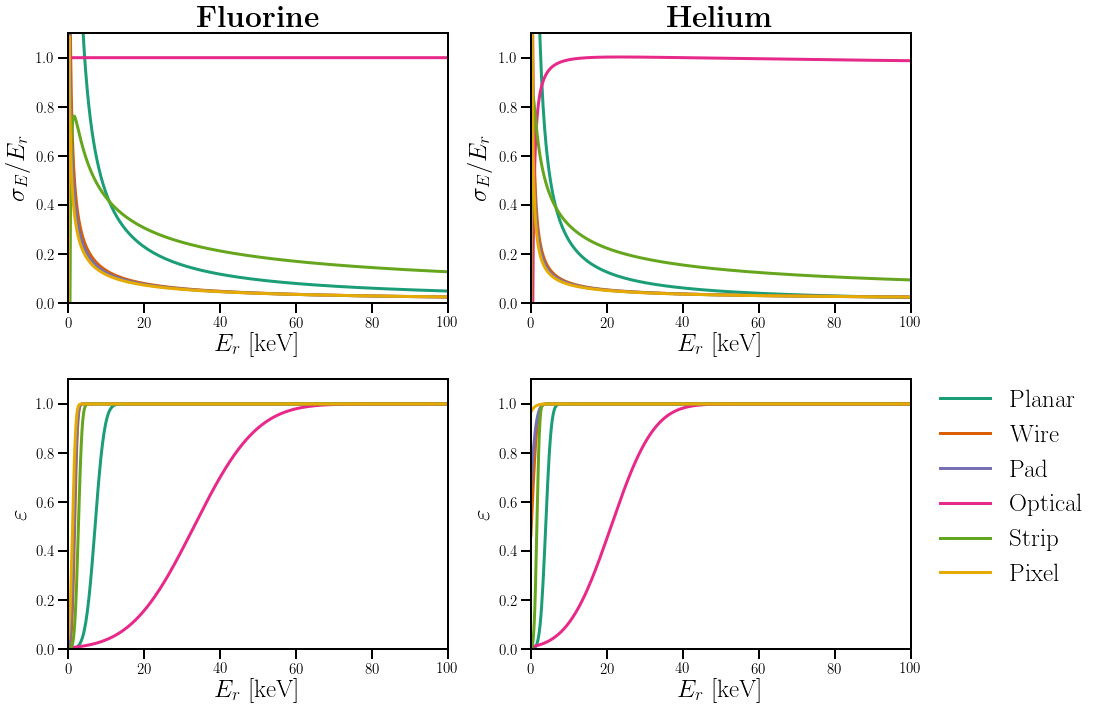

In [9]:
from numpy import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.special import erf
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

plt.rcParams['axes.linewidth'] = 2
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

col = cm.Dark2(linspace(0,1,8))

fig, ax = plt.subplots(2,2)
fig.set_size_inches(13,10)

smooth_w = 11
smooth_i = 2
def eff_func(z,a,b):
    return 0.5*(erf((z-a)/b)+1);

#def energyres_func(z,a,b):
#    return a/(b*sqrt(z)+1);
def energyres_func(z,a,b,c):
    return a*z**(1.0/b) + c
mrkz = ['.','o','v','s','d','p']

# Sven's names
readouts = ["" for x in range(0,6)]
readouts[0] = "gem"
readouts[1] = "wir"
readouts[2] = "pad"
readouts[3] = "opt"
readouts[4] = "str"
readouts[5] = "pix"

# My names
froot_er = "-EnergyRes.txt"
fdir_er = "../readouts/energyres/"
froot_eff = "-Efficiency.txt"
fdir_eff = "../readouts/efficiency/"
fname = ["" for x in range(0,6)]
fname[0] ="Planar"
fname[1] ="Wire"
fname[2] ="Pad"
fname[3] ="Optical"
fname[4] ="Strip"
fname[5] ="Pixel"

nE = 1000
E_max = 200.0
Evals = linspace(0.000001, E_max, nE)

for ro_i in range(0,6):
    ro1 = readouts[ro_i]
    filename = fname[ro_i]

    data_eff = zeros(shape=(nE,3))
    F_eff = zeros(shape=(75,2))
    He_eff = zeros(shape=(75,2))
    f=open('../readouts/simulationdata/charge_efficiency.txt','r')
    i1 = 0
    i2 = 0
    for line in f:
        a = line.split()
        nuc = a[7]
        ro = a[9]
        if ro==ro1:
            if nuc=='helium':
                He_eff[i1,0] = a[8]
                He_eff[i1,1] = a[10]
                i1 = i1+1
            else:
                F_eff[i2,0] = a[8]
                F_eff[i2,1] = a[10]
                i2 = i2+1              
    He_eff = He_eff[0:i1,:]
    F_eff = F_eff[0:i2,:]
    pF,pcov = curve_fit(eff_func,F_eff[:,0], F_eff[:,1])
    pHe,pcov = curve_fit(eff_func,He_eff[:,0], He_eff[:,1])
    data_eff[:,0] = Evals
    data_eff[:,1] = eff_func(Evals,*pF)
    data_eff[:,2] = eff_func(Evals,*pHe)
    
    
    F_er = zeros(shape=(75,2))
    He_er = zeros(shape=(75,2))
    data_er = zeros(shape=(nE,3))
    f=open('../readouts/simulationdata/energy_resolution.txt','r')
    i1 = 0
    i2 = 0
    for line in f:
        a = line.split()
        nuc = a[4]
        ro = a[6]
        if ro==ro1:
            if nuc=='helium':
                He_er[i1,0] = a[5]
                He_er[i1,1] = a[7]
                i1 = i1+1
            else:
                F_er[i2,0] = a[5]
                F_er[i2,1] = a[7]
                i2 = i2+1              
    He_er = He_er[0:i1,:]
    F_er = F_er[0:i2,:]
    He_er[He_er[:,1]>1.0,1] = 1.0
    F_er[F_er[:,1]>1.0,1] = 1.0
    pF,pcov = curve_fit(energyres_func,F_er[:,0], F_er[:,1]*F_er[:,0])
    pHe,pcov = curve_fit(energyres_func,He_er[:,0], He_er[:,1]*He_er[:,0])
    data_er[:,0] = Evals
    data_er[:,1] = energyres_func(Evals,*pF)/Evals
    data_er[:,2] = energyres_func(Evals,*pHe)/Evals
    data_er[0,1:] = 0.0

    plt.sca(ax[0,0])
    #y = savgol_filter(F_er[:,1], smooth_w, smooth_i)
    #plt.plot(F_er[:,0],y,'--',linewidth=3,color=col[ro_i,:])
    #plt.plot(F_er[:,0],F_er[:,1],mrkz[ro_i],color=col[ro_i,:],linewidth=3,markersize=8)
    plt.plot(data_er[:,0],data_er[:,1],'-',color=col[ro_i,:],linewidth=3)
    plt.title(r"{\bf Fluorine}",fontsize=30)
    plt.xlabel(r"$E_r$ [keV]",fontsize=25)
    plt.ylabel(r"$\sigma_E/E_r$",fontsize=25)
    ax[0,0].set_ylim(bottom=0, top=1.1)
    ax[0,0].set_xlim(0,100)
    ax[0,0].tick_params(which='major',direction='out',width=2,length=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.sca(ax[0,1])
    #y = savgol_filter(He_er[:,1], smooth_w, smooth_i)
    #plt.plot(He_er[:,0],y,'--',linewidth=3,color=col[ro_i,:])
    #plt.plot(He_er[:,0],He_er[:,1],mrkz[ro_i],color=col[ro_i,:],linewidth=3,markersize=8)
    plt.plot(data_er[:,0],data_er[:,2],'-',color=col[ro_i,:],linewidth=3)
    plt.title(r"{\bf Helium}",fontsize=30)
    plt.xlabel(r"$E_r$ [keV]",fontsize=25)
    plt.ylabel(r"$\sigma_E/E_r$",fontsize=25)
    ax[0,1].set_ylim(bottom=0, top=1.1)
    ax[0,1].set_xlim(0,100)
    ax[0,1].tick_params(which='major',direction='out',width=2,length=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.sca(ax[1,0])
    #y = savgol_filter(He_eff[:,1], smooth_w, smooth_i)
    #plt.plot(F_eff[:,0],y,'--',linewidth=3,color=col[ro_i,:])
    #plt.plot(F_eff[:,0],F_eff[:,1],mrkz[ro_i],color=col[ro_i,:],linewidth=3,markersize=8)
    plt.plot(data_eff[:,0],data_eff[:,1],'-',color=col[ro_i,:],linewidth=3)
    plt.xlabel(r"$E_r$ [keV]",fontsize=25)
    plt.ylabel(r"$\varepsilon$",fontsize=25)
    ax[1,0].set_ylim(bottom=0, top=1.1)
    ax[1,0].set_xlim(0,100)
    ax[1,0].tick_params(which='major',direction='out',width=2,length=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #ax[1,0].set_xscale('log')

    
    plt.sca(ax[1,1])
    #y = savgol_filter(He_eff[:,1], smooth_w, smooth_i)
    #plt.plot(He_eff[:,0],y,'--',linewidth=3,color=col[ro_i,:])
    #plt.plot(He_eff[:,0],He_eff[:,1],mrkz[ro_i],color=col[ro_i,:],linewidth=3,markersize=8)
    plt.plot(data_eff[:,0],data_eff[:,2],'-',color=col[ro_i,:],linewidth=3)
    plt.xlabel(r"$E_r$ [keV]",fontsize=25)
    plt.ylabel(r"$\varepsilon$",fontsize=25)
    ax[1,1].set_ylim(bottom=0, top=1.1)
    ax[1,1].set_xlim(0,100)
    ax[1,1].tick_params(which='major',direction='out',width=2,length=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #ax[1,1].set_xscale('log')

    savetxt(fdir_er+fname[ro_i]+froot_er,data_er, delimiter='\t')
    savetxt(fdir_eff+fname[ro_i]+froot_eff,data_eff, delimiter='\t')

        
    f.close()    

# Use pixel efficiency and resolution for non-directional readout
savetxt(fdir_eff+"Nondirectional"+froot_eff,data_eff, delimiter='\t')
savetxt(fdir_er+"Nondirectional"+froot_er,data_er, delimiter='\t')

# Use the pixel readout energy resolution for the post-drift and pre-drift
# but perfect efficiency (i.e. all charge is detected)
data_eff[:,1] = 1.0
data_eff[:,2] = 1.0
savetxt(fdir_er+"Predrift"+froot_er,data_er, delimiter='\t')
savetxt(fdir_eff+"Predrift"+froot_eff,data_eff, delimiter='\t')
savetxt(fdir_er+"Postdrift"+froot_er,data_er, delimiter='\t')
savetxt(fdir_eff+"Postdrift"+froot_eff,data_eff, delimiter='\t')

fig.tight_layout()   
plt.sca(ax[1,1])
for i in range(0,6):
    plt.plot(-1,-1,linewidth=3,color=col[i,:],label=fname[i])
#plt.plot([-1,-2],[-1,-2],'k--',linewidth=3,label=r'{\bf Smooth}')
#plt.plot([-1,-2],[-1,-2],'k-',linewidth=3,label=r'{\bf Fit}')
plt.legend(fontsize=25,frameon=False,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
#
fig.savefig('../plots/energy-performance.pdf',bbox_inches='tight')

# Perfect efficiency and resolution for idealised readout
data_er[:,1] = 0.0
data_er[:,2] = 0.0
savetxt(fdir_er+"Ideal"+froot_er,data_er, delimiter='\t')
savetxt(fdir_eff+"Ideal"+froot_eff,data_eff, delimiter='\t')
